In [2]:
import sys
!{sys.executable} -m pip install json_stream
import numpy as np
import pandas as pd
import json_stream
import json

Defaulting to user installation because normal site-packages is not writeable


In [43]:
with open("dawn-event-data.json") as f:
    data = json.load(f)
    print(len(data))
    print("DONE!")

11058699
DONE!


## Preprocessing the data

Get data regarding player interactions from the given dataset.

In [256]:
# Get player pos
def player_data(id):
  pos = [x for x in data if x['userId'] == id]
  return pos

def get_pos(d):
  pos = [x['position'] for x in d]
  x = [pos[0] for pos in pos]
  y = [pos[1] for pos in pos]
  z = [pos[2] for pos in pos]
  return x,y,z

def close_enough(pos1, pos2):
  dist = ((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2 + (pos1[2] - pos2[2])**2)**0.5
  return (dist <= 5, dist)

def get_players_near_pos(d, pos):
  return [(event['userId'], close_enough(event['position'], pos)[1]) for event in d if close_enough(event['position'], pos)[0]]

def get_event(d, event):
  events = [x for x in d if event in x['events']]
  return events

def get_unique_times(d):
  times = list(set([x['time'] for x in d]))
  return times

In [77]:
import matplotlib.pyplot as plt
import numpy as np

In [88]:
def plot_players_and_events(players, event):
  fig = plt.figure()
  ax = plt.axes(projection ='3d')

  for i in players:
    color = (np.random.random(), np.random.random(), np.random.random())
    player = player_data(i)
    events = get_event(player, event)
    x,y,z = get_pos(player)
    ex, ey, ez = get_pos(events)
    ax.scatter(ex, ey, ez, marker="o", label=f'Player {i}, {event}', color=color)
    ax.plot3D(x, y, z, label=f'Player {i}', color=color)
    ax.scatter(x[0],y[0],z[0], marker="x", label=f'Player {i} start', color=color)

  ax.legend()
  ax.set_xlabel('x-axis')
  ax.set_ylabel('y-axis')
  ax.set_zlabel('z-axis')
  ax.set_title('Plot of position and position of events')
  plt.show()


In [ ]:
# Stratisfy the data by every 100 events and search within to check for any hand holding and any nearby players
step = 100
idx = 0

interactions = []
interaction_with_dists = []

while idx < len(data):
  # Get all events during this chunk of time
  events = data[idx:idx + step]
  hand_hold_event = [(event['userId'], event['position']) for event in events if "hand_held" in event["events"]]
  if hand_hold_event:
    people = get_players_near_pos(events, hand_hold_event[0][1])
    if len(people) > 1:
      interactions.append([x[0] for x in people])
      interaction_with_dists.append(people)

  idx += step

# The list of groups of handholders
interactions


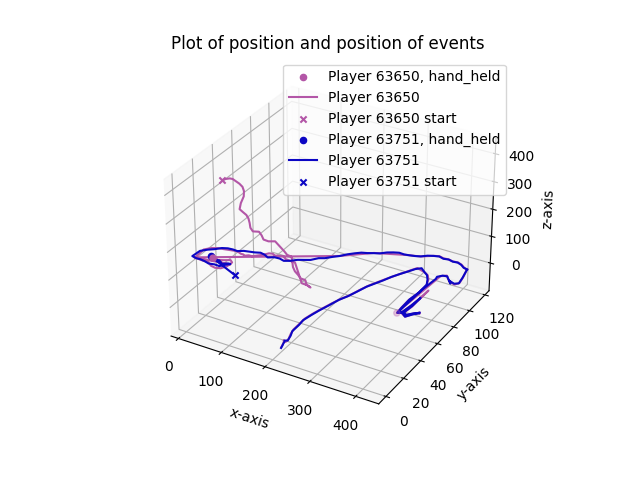

In [146]:
# Plot a pair of handholders to see their path
%matplotlib widget
plot_players_and_events([63650, 63751], "hand_held")

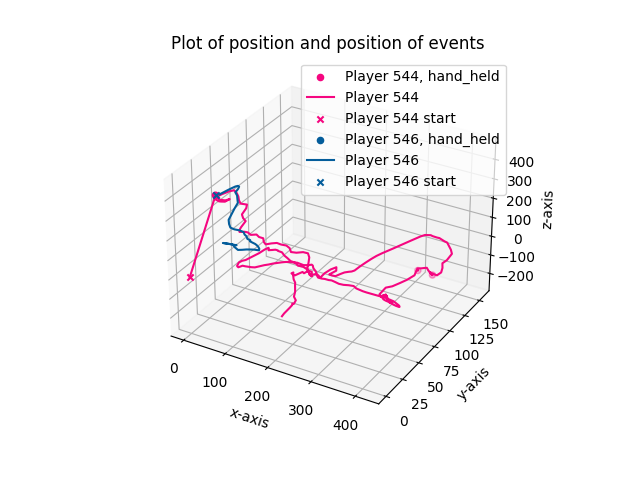

In [213]:
%matplotlib widget
plot_players_and_events([544, 546], "hand_held")

In [175]:
def get_player_interactions(player):
  return [x for x in interactions if player in x]

def get_timeframe_of_interaction(interaction):
  idx = interactions.index(interaction)
  first = idx * 100
  last = first + 100
  return data[first]['time'], data[last]['time']


In [182]:
get_timeframe_of_interaction(get_player_interactions(544)[0])

(1664339230011, 1664339231033)

## In-game purchase and player interaction

In [311]:
# Out of the people who bought a candle within the timeframe of the dataset, did they make any interactions?

players_purchasing = set([x['userId'] for x in data if 'candle_purchased' in x['events']])

num_inter = 0
player_purchasing_interactions = []
for player in players_purchasing:
  inter = get_player_interactions(player)
  if inter:
    player_purchasing_interactions.append(inter)
    num_inter += 1

In [295]:
max(player_purchasing_interactions, key=len)

[[32901, 32934, 32935, 32936],
 [32895, 32941, 32935],
 [33029, 32935],
 [267, 32935, 32934],
 [33805, 32935],
 [33624, 32935],
 [33871, 33872, 32935],
 [34218, 34219, 34220, 32935],
 [32935, 34239],
 [34978, 32935, 34977, 34980],
 [35072, 32935],
 [1527, 32935],
 [35340, 35373, 32935, 35193],
 [35651, 32935, 17305],
 [35924, 32935],
 [36482, 36549, 32935, 36550]]

In [225]:
print("# of people who bought candle and made interactions:", num_inter)
print("# of people who bought candle but made no interactions:", len(players_purchasing) - num_inter)

# of people who bought candle and made interactions: 63
# of people who bought candle but made no interactions: 127


The in-app purchases don't seem to be promoting the game's theme of communication and interaction with others.

The players who buy candles would be expected to make more interactions (i.e holding hands or making more friends with others)

However, from this data, it seems that more people buy candles but end up not making interactions like holding hands at all.

In [274]:
from itertools import combinations
def network_interaction_of_player(player):
  G = nx.Graph()
  # Plotting first five interactions
  inters = get_player_interactions(player)
  print(inters)
  for interaction in inters:
    combs = list(combinations(interaction, 2))
    G.add_edges_from(combs)

  fig = plt.figure()
  ax = plt.axes()
  ax.set_title(f"Interactions graph of Player #{player}")
  nx.draw(G, node_size=0, alpha=0.4, edge_color="r", font_size=16, with_labels=True)
  

[[39665, 39753, 36851], [57075, 47342, 15438, 36851, 57014]]


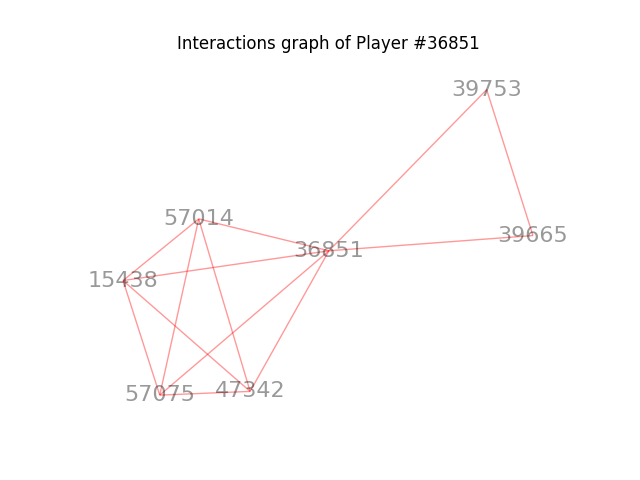

In [275]:
network_interaction_of_player(36851)

[[40587, 40589, 40585], [6134, 40589], [44589, 56361, 40589, 40585, 54962], [40589, 63923]]


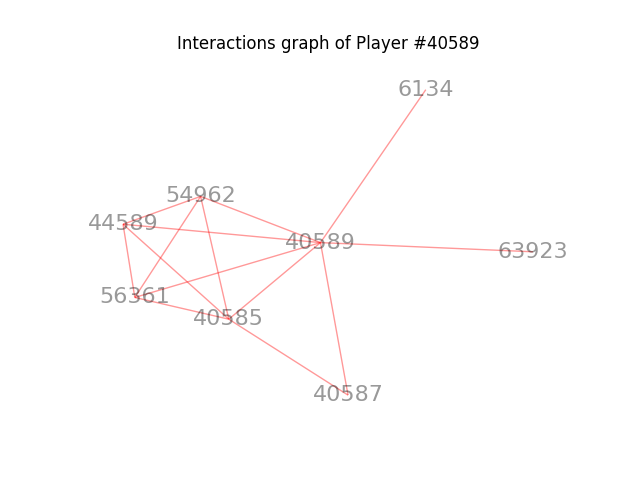

In [276]:
network_interaction_of_player(40589)

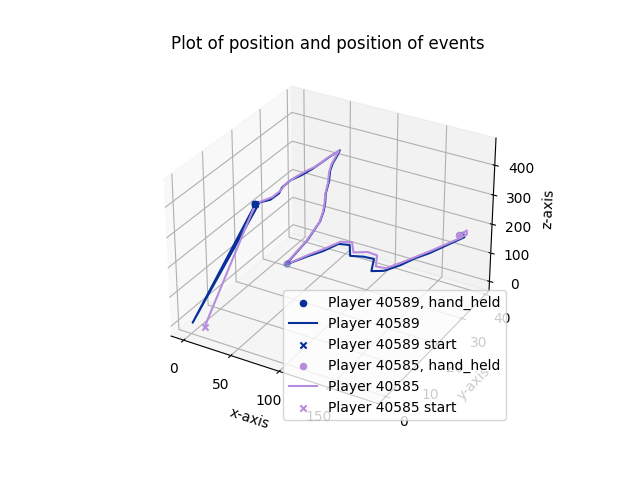

In [277]:
# Beautiful friendship <3
plot_players_and_events([40589, 40585], "hand_held")

## Interesting finds:


**Super-networker**: The following player made hand-holds with quite a lot of players. This already seems a little suspicious.

[[32901, 32934, 32935, 32936], [32895, 32941, 32935], [33029, 32935], [267, 32935, 32934], [33805, 32935], [33624, 32935], [33871, 33872, 32935], [34218, 34219, 34220, 32935], [32935, 34239], [34978, 32935, 34977, 34980], [35072, 32935], [1527, 32935], [35340, 35373, 32935, 35193], [35651, 32935, 17305], [35924, 32935], [36482, 36549, 32935, 36550]]


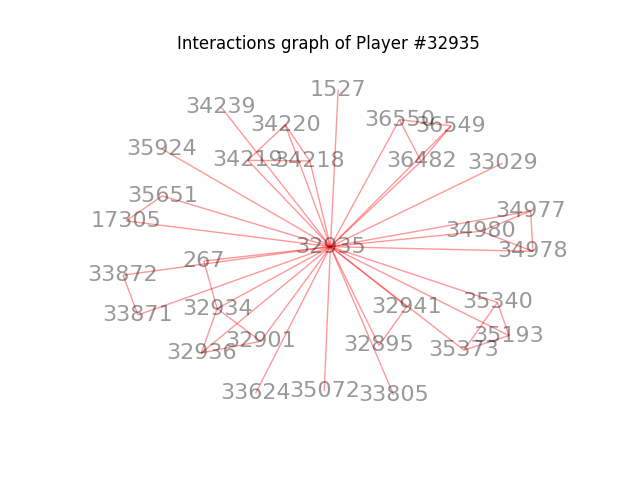

In [296]:
# Sus? So many connections
network_interaction_of_player(32935)

**Finding friends? A troll?** The player below starts at a location where most other players end, and seems to be circling around a lot around the area where players usually start the game. The player makes no interactions with anyone. Not sure if this is to annoy the new players.

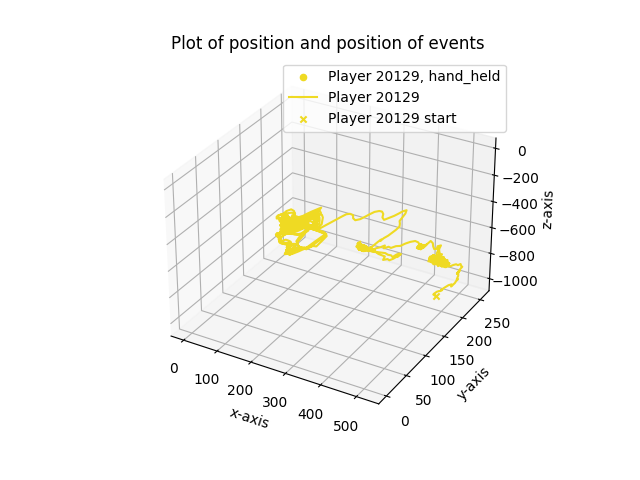

In [302]:
plot_players_and_events([20129], "hand_held")

**Sabotaging other interactions?** The network graph of the player shows multiple interactions with other players, but the plot of the player's movement shows erratic behavior and shows they never initiated these hand-holds.

These players could be accepting an hand hold invitation meant for someone else and looping around the popular social areas frequently in order to sabotage more.

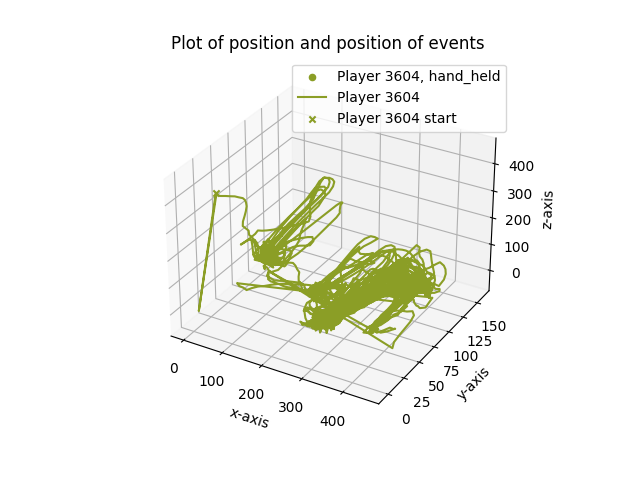

[[3604, 3605, 3576, 3560, 3606], [5512, 5505, 3604]]


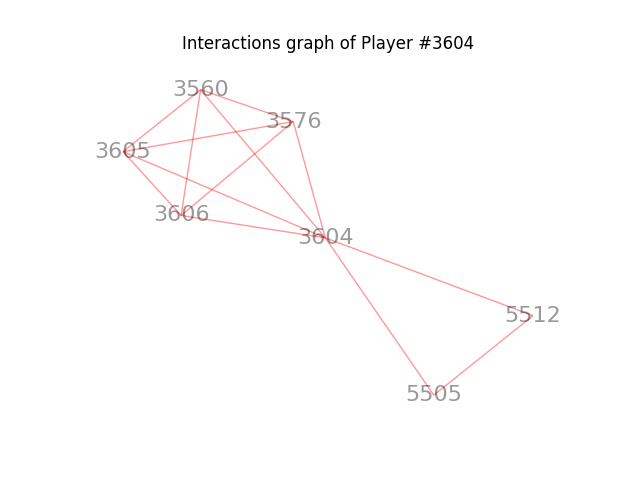

In [318]:
plot_players_and_events([3604], "hand_held")
network_interaction_of_player(3604)
# Didn't initiate any of the hand holding, but interacted (hand held) by others

## Pings analysis

We noticed that there was an anomaly with the number of pings some users made throughout the dataset.

In [315]:
pings = [x['events']['ping'] for x in data if 'ping' in x['events']]

Text(0.5, 0, '# of Pings')

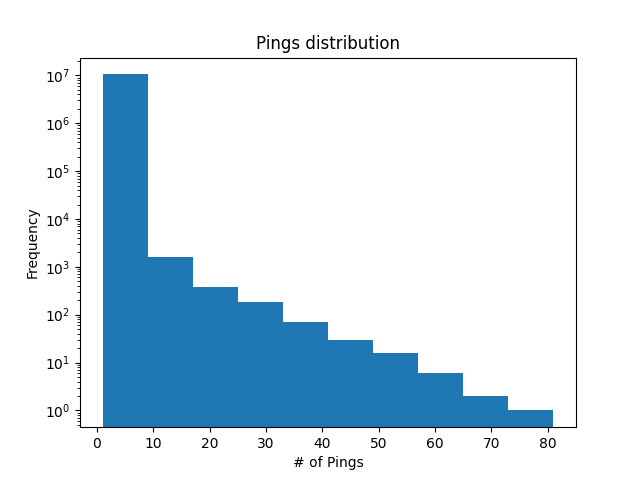

In [322]:
fig = plt.figure()
ax = plt.axes()
ax.hist(pings, log=True)
ax.set_title("Pings distribution")
ax.set_ylabel("Frequency")
ax.set_xlabel("# of Pings")